In [1]:
import numpy as np
from collections import Counter
import networkx as nx
from infomap import infomap
import community

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (8, 6)
rcParams['axes.titlepad'] = 12
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 12

In [2]:
def findInfomapCommunities(G, N=10):
    """
    Partition a networkx graph G with the Infomap algorithm.
    Annotates nodes with 'community' id and returns the number of communities found.
    """
    
    infomapWrapper = infomap.Infomap("--two-level -0 -N{}".format(N))

    for e in G.edges():
        infomapWrapper.addLink(*e)
    
    infomapWrapper.run();
    tree = infomapWrapper.tree

    partition = {}
    for node in tree.leafIter():
        partition[node.originalLeafIndex] = node.moduleIndex()

    nx.set_node_attributes(G, name='community', values=partition)
    return tree.numTopModules()

In [3]:
def findLouvainCommunities(G, N=10):
    """
    Partition a networkx graph G with the Louvain algorithm.
    Annotates nodes with 'community' id and returns the number of communities found.
    """
    best_partition = None
    best_modularity = float("inf")
    for i in range(N):
        partition = community.best_partition(G, randomize=True)
        if community.modularity(partition, G) < best_modularity:
            best_partition = partition
    nx.set_node_attributes(G, name='community', values=best_partition)
    return len(Counter(best_partition.values()))

In [4]:
file = "averaged_matrix_weighted.csv"
csvfile = open(file, 'rb')
data = np.genfromtxt(csvfile, delimiter=',', dtype=None)
maxValue = np.max(data)
graph_data = data/maxValue
print(maxValue)

4593.30622757


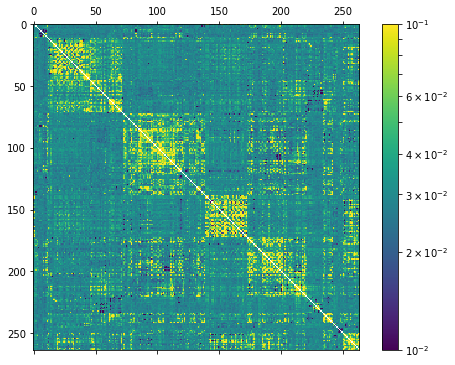

In [5]:
fig, ax = plt.subplots()
cax = ax.matshow(graph_data, interpolation='nearest', norm=colors.LogNorm(vmin=0.01, vmax=0.1))
fig.colorbar(cax);

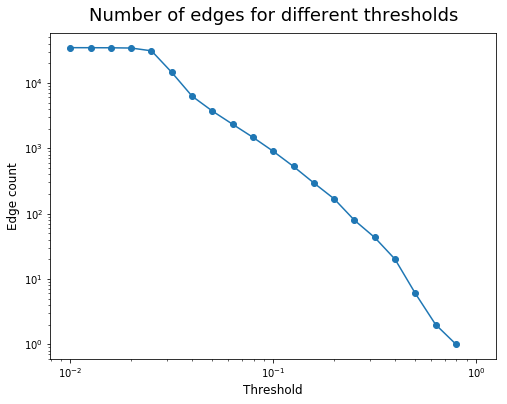

In [13]:
thresholds = np.logspace(-2, 0, 21)
num_edges = [(graph_data > t).sum()/2 for t in thresholds]
fig, ax = plt.subplots()
ax.plot(thresholds, num_edges, '-o');
ax.set_yscale('log');
ax.set_xscale('log');
ax.set_title('Number of edges for different thresholds');
ax.set_ylabel('Edge count');
ax.set_xlabel('Threshold');

In [7]:
def getNetwork(threshold):
    g  = nx.Graph()
    g.add_nodes_from(list (range (0, 264)))

    for i1, data1 in enumerate(graph_data):
        for i2, data2 in enumerate(graph_data):
            if graph_data[i1][i2] >= threshold:
                g.add_edge(i1, i2, weight = graph_data[i1][i2])
    return g

In [8]:
louvainModuleCount = []
infomapModuleCount = []
for t in thresholds:
    print("Finding communities with threshold {}...".format(t))
    infomapModuleCount.append(findInfomapCommunities(getNetwork(t), N=10))
    louvainModuleCount.append(findLouvainCommunities(getNetwork(t), N=3))

Finding communities with threshold 0.01...
Finding communities with threshold 0.012589254117941675...
Finding communities with threshold 0.015848931924611134...
Finding communities with threshold 0.0199526231496888...
Finding communities with threshold 0.025118864315095794...
Finding communities with threshold 0.03162277660168379...
Finding communities with threshold 0.039810717055349734...
Finding communities with threshold 0.05011872336272725...
Finding communities with threshold 0.06309573444801933...
Finding communities with threshold 0.07943282347242814...
Finding communities with threshold 0.1...
Finding communities with threshold 0.12589254117941676...
Finding communities with threshold 0.15848931924611143...
Finding communities with threshold 0.19952623149688797...
Finding communities with threshold 0.25118864315095807...
Finding communities with threshold 0.31622776601683794...
Finding communities with threshold 0.3981071705534973...
Finding communities with threshold 0.501187

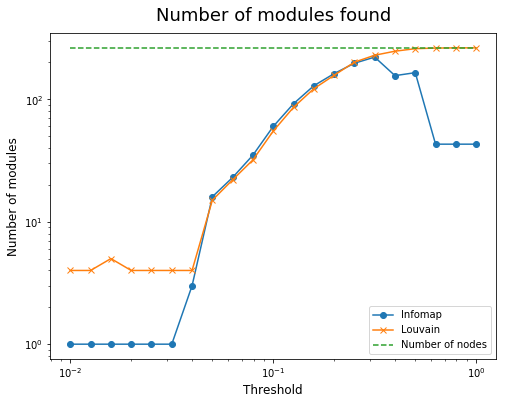

In [9]:
fig, ax = plt.subplots()
ax.plot(thresholds, infomapModuleCount, '-o');
ax.plot(thresholds, louvainModuleCount, '-x');
ax.plot((0.01, 1), (264, 264), '--');
ax.legend(['Infomap', 'Louvain', 'Number of nodes'], loc='lower right');
ax.set_ylabel('Number of modules')
ax.set_xlabel('Threshold')
ax.set_title('Number of modules found')
ax.set_yscale('log')
ax.set_xscale('log')
